<a href="https://colab.research.google.com/github/tzuyichao/python-basic/blob/master/colab/chapter3_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
print(train_labels[0])

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels[0])

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
def conv(filters, kernel_size, strides=1):
  return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))
  

In [5]:
def first_residual_unit(filters, strides):
  def f(x):
    x = BatchNormalization()(x)
    x_b = Activation('relu')(x)
    x = conv(filters // 4, 1, strides)(x_b)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(filters, 1)(x)
    x_b = conv(filters, 1, strides)(x_b)
    return Add()([x, x_b])
  return f


In [6]:
def residual_unit(filters):
  def f(x):
    x_b = x
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(filters // 4, 1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(filters, 1)(x)
    return Add()([x, x_b])
  return f


In [7]:
def residual_block(filters, strides, unit_size):
  def f(x):
    x = first_residual_unit(filters, strides)(x)
    for i in range(unit_size-1):
      x = residual_unit(filters)(x)
    return x
  return f


In [8]:
input = Input(shape=(32, 32, 3))
x = conv(16, 3)(input)
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=input, outputs=output)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [10]:
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, width_shift_range=0.125, height_shift_range=0.125, horizontal_flip=True)

test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

for data in (train_gen, test_gen):
  data.fit(train_images)

In [11]:
def step_decay(epoch):
  x = 0.1
  if epoch >= 80:
    x = 0.01
  if epoch >= 120:
    x = 0.0001
  return x
lr_decay = LearningRateScheduler(step_decay)

In [12]:
batch_size = 128
history = model.fit(train_gen.flow(train_images, train_labels, batch_size=batch_size), epochs=120, steps_per_epoch = train_images.shape[0] // batch_size, 
validation_data=test_gen.flow(test_images, test_labels, batch_size = batch_size), validation_steps=test_images.shape[0] // batch_size, callbacks=[lr_decay])

Epoch 1/120
390/390 [==============================] - 86s 183ms/step - loss: 4.6987 - acc: 0.2865 - val_loss: 4.7184 - val_acc: 0.3399
Epoch 2/120
390/390 [==============================] - 68s 175ms/step - loss: 3.8521 - acc: 0.4932 - val_loss: 3.5594 - val_acc: 0.5457
Epoch 3/120
390/390 [==============================] - 68s 175ms/step - loss: 3.2582 - acc: 0.6016 - val_loss: 3.2308 - val_acc: 0.5952
Epoch 4/120
390/390 [==============================] - 68s 175ms/step - loss: 2.7818 - acc: 0.6831 - val_loss: 2.7996 - val_acc: 0.6424
Epoch 5/120
390/390 [==============================] - 68s 175ms/step - loss: 2.4258 - acc: 0.7328 - val_loss: 2.4156 - val_acc: 0.6892
Epoch 6/120
390/390 [==============================] - 68s 175ms/step - loss: 2.1535 - acc: 0.7582 - val_loss: 2.0596 - val_acc: 0.7510
Epoch 7/120
390/390 [==============================] - 68s 175ms/step - loss: 1.9229 - acc: 0.7852 - val_loss: 1.9004 - val_acc: 0.7569
Epoch 8/120
390/390 [===========================

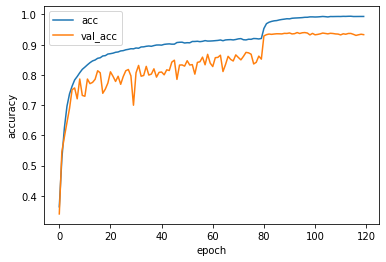

In [13]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_gen.flow(test_images, test_labels))
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

313/313 [==============================] - 7s 23ms/step - loss: 0.4474 - acc: 0.9334
loss: 0.447
acc: 0.933


In [17]:
test_predictions = model.predict(test_gen.flow(test_images[0:10], shuffle=False))
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
test_ans = np.argmax(test_labels[:10], axis=1)
print('前10筆測試標籤:', [labels[n] for n in test_ans])
print('前10筆預測標籤:', [labels[n] for n in test_predictions])

前10筆測試標籤: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']
前10筆預測標籤: ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']
